Beta Oxidation with Reaction SMART
This notebook implements detailed chemical transformations for fatty acid beta-oxidation using RDKit's reaction SMARTS capabilities

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True  # For better visualization in notebook

# Import Ema's code (saved in a file called fatty_acid.py)
import sys
sys.path.append(r'C:\Users\ipeki\git\Lynen-s_Spiral\Lynen-s_Spiral\src\lynen_spiral')
from fatty_acid import FattyAcidMetabolism, FattyAcidType

# Common fatty acid names to SMILES dictionary
FATTY_ACIDS = {
    "palmitic acid": "CCCCCCCCCCCCCCCC(=O)O",    # C16:0
    "stearic acid": "CCCCCCCCCCCCCCCCCC(=O)O",   # C18:0
    "oleic acid": "CCCCCCCCC=CCCCCCCC(=O)O",     # C18:1(9)
    "linoleic acid": "CCCCCC=CCC=CCCCCCC(=O)O",  # C18:2(9,12)
    "alpha-linolenic acid": "CCC=CCC=CCC=CCCCCCC(=O)O",  # C18:3(9,12,15)
    "arachidonic acid": "CCCC=CCC=CCC=CCC=CCCCC(=O)O"    # C20:4(5,8,11,14)
}

In [ ]:
class EnhancedFattyAcidMetabolism(FattyAcidMetabolism):
    """Enhanced version of FattyAcidMetabolism with reaction SMARTS implementation."""
    
    def __init__(self, input_value):
        """
        Initialize with either a SMILES string, fatty acid name, or notation like C18:2(9,12)
        
        Parameters
        ----------
        input_value : str
            SMILES string, common name, or notation for a fatty acid
        """
        # Process input based on format
        smiles = self._process_input(input_value)
        
        # Initialize using parent class
        super().__init__(smiles)
        
        # Additional properties
        self.reaction_steps = []
        self.reaction_results = []
        self.reaction_descriptions = []
        
    def _process_input(self, input_value):
        """Convert various input formats to SMILES."""
        # Check if input is already a SMILES string
        if "(" in input_value and ")" in input_value and "O" in input_value:
            return input_value
            
        # Check if input is a common fatty acid name
        if input_value.lower() in FATTY_ACIDS:
            return FATTY_ACIDS[input_value.lower()]
            
        # Check if input is in CX:Y(pos1,pos2,...) notation
        if input_value.startswith('C') and ':' in input_value:
            return self._notation_to_smiles(input_value)
            
        raise ValueError("Unrecognized fatty acid format. Please use SMILES, common name, or CX:Y notation.")
    
    def _notation_to_smiles(self, notation):
        """Convert notation like C18:2(9,12) to SMILES."""
        # Parse notation
        chain_part = notation.split(':')[0]
        chain_length = int(chain_part[1:])
        
        if '(' in notation:
            db_part = notation.split(':')[1]
            double_bond_count = int(db_part.split('(')[0])
            positions_str = db_part.split('(')[1].replace(')', '')
            double_bond_positions = [int(pos) for pos in positions_str.split(',')]
        else:
            double_bond_count = int(notation.split(':')[1])
            double_bond_positions = []
        
        # Build a basic chain
        chain = "C" * chain_length
        
        # Add double bonds if specified
        if double_bond_positions:
            # This is simplified - would need more sophisticated logic for proper geometry
            # For now, just placing double bonds at specified positions
            for pos in double_bond_positions:
                # Adjust because SMILES indices start at 0
                pos_adjusted = pos - 1
                if pos_adjusted < len(chain) - 1:
                    chain = chain[:pos_adjusted] + "C=C" + chain[pos_adjusted+2:]
        
        # Add carboxylic acid group
        smiles = chain + "(=O)O"
        return smiles
    
    # Reaction SMARTS implementation for activation (acyl-CoA synthetase)
    def activate_fatty_acid(self):
        """
        Activate fatty acid by converting to acyl-CoA.
        This process consumes 2 ATP equivalent.
        """
        # Define activation reaction using reaction SMARTS
        activation_rxn = AllChem.ReactionFromSmarts("[C:1](=[O:2])[O:3][H] >> [C:1](=[O:2])[S]CoA")
        
        # Prepare reactant
        reactant = self.molecule
        
        # Run reaction
        products = activation_rxn.RunReactants((reactant,))
        
        if not products or len(products) == 0:
            raise ValueError("Activation reaction failed")
        
        # Get the product molecule
        activated_mol = products[0][0]
        
        # Add hydrogens for better visualization
        activated_mol = Chem.AddHs(activated_mol)
        
        # Store reaction information
        self.reaction_steps.append("Activation")
        self.reaction_results.append(activated_mol)
        self.reaction_descriptions.append("Conversion to acyl-CoA via acyl-CoA synthetase (2 ATP cost)")
        
        return activated_mol
    
    # Implement carnitine shuttle
    def carnitine_shuttle(self, acyl_coa_mol):
        """
        Simulate transport of acyl-CoA into mitochondria via carnitine shuttle.
        This is a multi-step process:
        1. Acyl-CoA + Carnitine → Acylcarnitine + CoA (via CPT1)
        2. Transport across membrane
        3. Acylcarnitine + CoA → Acyl-CoA + Carnitine (via CPT2)
        """
        # For simplicity, we'll simulate this without actual reaction SMARTS
        # In a real implementation, you'd model each step
        
        # Store reaction information
        self.reaction_steps.append("Transport")
        self.reaction_results.append(acyl_coa_mol)  # No molecular change, just location
        self.reaction_descriptions.append("Transport into mitochondria via carnitine shuttle")
        
        return acyl_coa_mol
    
    # Example of one beta-oxidation cycle with reaction SMARTS
    def beta_oxidation_cycle(self, acyl_coa_mol):
        """
        Perform one complete beta-oxidation cycle:
        1. Dehydrogenation (FAD → FADH₂)
        2. Hydration
        3. Oxidation (NAD⁺ → NADH)
        4. Thiolysis
        """
        # Step 1: Dehydrogenation (FAD → FADH₂)
        dehydrogenation_rxn = AllChem.ReactionFromSmarts(
            "[C:1][C:2][C:3][C:4](=[O:5])[S:6]CoA >> [C:1]=[C:2][C:3][C:4](=[O:5])[S:6]CoA"
        )
        
        # Run reaction
        products = dehydrogenation_rxn.RunReactants((acyl_coa_mol,))
        if not products or len(products) == 0:
            raise ValueError("Dehydrogenation reaction failed")
        
        trans_enoyl_coa = products[0][0]
        
        # Store step information
        self.reaction_steps.append("Dehydrogenation")
        self.reaction_results.append(trans_enoyl_coa)
        self.reaction_descriptions.append("Dehydrogenation (FAD → FADH₂)")
        
        # Step 2: Hydration
        hydration_rxn = AllChem.ReactionFromSmarts(
            "[C:1]=[C:2][C:3][C:4](=[O:5])[S:6]CoA >> [C:1]([O:7][H])[C:2][C:3][C:4](=[O:5])[S:6]CoA"
        )
        
        # Run reaction
        products = hydration_rxn.RunReactants((trans_enoyl_coa,))
        if not products or len(products) == 0:
            raise ValueError("Hydration reaction failed")
        
        beta_hydroxyacyl_coa = products[0][0]
        
        # Store step information
        self.reaction_steps.append("Hydration")
        self.reaction_results.append(beta_hydroxyacyl_coa)
        self.reaction_descriptions.append("Hydration (addition of H₂O)")
        
        # Step 3: Oxidation (NAD⁺ → NADH)
        oxidation_rxn = AllChem.ReactionFromSmarts(
            "[C:1]([O:7][H])[C:2][C:3][C:4](=[O:5])[S:6]CoA >> [C:1](=[O:7])[C:2][C:3][C:4](=[O:5])[S:6]CoA"
        )
        
        # Run reaction
        products = oxidation_rxn.RunReactants((beta_hydroxyacyl_coa,))
        if not products or len(products) == 0:
            raise ValueError("Oxidation reaction failed")
        
        beta_ketoacyl_coa = products[0][0]
        
        # Store step information
        self.reaction_steps.append("Oxidation")
        self.reaction_results.append(beta_ketoacyl_coa)
        self.reaction_descriptions.append("Oxidation (NAD⁺ → NADH)")
        
        # Step 4: Thiolysis (cleavage with CoA)
        thiolysis_rxn = AllChem.ReactionFromSmarts(
            "[C:1](=[O:7])[C:2][C:3][C:4](=[O:5])[S:6]CoA >> [C:1](=[O:7])[S]CoA.[C:2][C:3][C:4](=[O:5])[S:6]CoA"
        )
        
        # Run reaction
        products = thiolysis_rxn.RunReactants((beta_ketoacyl_coa,))
        if not products or len(products) == 0:
            raise ValueError("Thiolysis reaction failed")
        
        # We get two products: acetyl-CoA and shortened acyl-CoA
        acetyl_coa = products[0][0]
        shortened_acyl_coa = products[0][1]
        
        # Store step information
        self.reaction_steps.append("Thiolysis")
        self.reaction_results.append(shortened_acyl_coa)  # Continue with shortened chain
        self.reaction_descriptions.append("Thiolysis (cleavage with CoA, producing acetyl-CoA)")
        
        return shortened_acyl_coa, acetyl_coa
    
    def run_complete_oxidation(self):
        """
        Run the complete beta-oxidation process from start to finish.
        """
        # Clear previous results
        self.reaction_steps = []
        self.reaction_results = []
        self.reaction_descriptions = []
        
        # Initial step: Activation
        current_mol = self.activate_fatty_acid()
        
        # Transport step: Carnitine shuttle
        current_mol = self.carnitine_shuttle(current_mol)
        
        # Initial properties
        chain_length = self._get_carbon_chain_length()
        cycles_needed = (chain_length - 2) // 2
        
        # Collect products
        acetyl_coa_count = 0
        propionyl_coa = None
        
        # Run cycles
        for cycle in range(cycles_needed):
            # Check for odd carbon handling in last cycle
            if cycle == cycles_needed - 1 and chain_length % 2 != 0:
                # Handle odd carbon chain differently for last cycle
                # This would need special implementation
                self.reaction_steps.append(f"Cycle {cycle+1}: Odd-chain final processing")
                self.reaction_descriptions.append("Processing final 3 carbons to propionyl-CoA")
                # Placeholder for propionyl-CoA
                propionyl_coa = current_mol
                break
            else:
                # Regular cycle
                self.reaction_steps.append(f"Cycle {cycle+1}")
                self.reaction_descriptions.append(f"Starting beta-oxidation cycle {cycle+1}")
                
                # Run one cycle
                current_mol, acetyl_coa = self.beta_oxidation_cycle(current_mol)
                acetyl_coa_count += 1
        
        # Final energy calculation
        energy_balance = self.calculate_atp_yield()
        
        return {
            'final_products': {
                'acetyl_coa_count': acetyl_coa_count,
                'propionyl_coa': propionyl_coa is not None
            },
            'reaction_steps': self.reaction_steps,
            'reaction_results': self.reaction_results,
            'reaction_descriptions': self.reaction_descriptions,
            'energy_balance': energy_balance
        }

In [ ]:
# Test functions
def test_fatty_acid_input(input_value):
    """Test function to process and display information about a fatty acid."""
    try:
        fa = EnhancedFattyAcidMetabolism(input_value)
        print(f"Successfully processed: {input_value}")
        print(f"Chain length: {fa.chain_length}")
        print(f"Double bonds: {fa.double_bonds}")
        print(f"Fatty acid type: {fa.type.value}")
        
        # Visualize molecule
        mol = fa.molecule
        return Draw.MolToImage(mol)
    except Exception as e:
        print(f"Error processing {input_value}: {str(e)}")
        return None

# Example usage
# test_fatty_acid_input("palmitic acid")

def visualize_beta_oxidation(input_value):
    """Run and visualize complete beta-oxidation process."""
    fa = EnhancedFattyAcidMetabolism(input_value)
    results = fa.run_complete_oxidation()
    
    # Display energy balance
    energy = results['energy_balance']
    print(f"ATP Yield Summary for {input_value}:")
    print(f"  Activation cost: {energy['activation_cost']} ATP")
    print(f"  β-oxidation cycles: {energy['β-oxidation_cycles']}")
    print(f"  ATP from FADH₂: {energy['FADH2_ATP']}")
    print(f"  ATP from NADH: {energy['NADH_ATP']}")
    print(f"  ATP from acetyl-CoA: {energy['acetyl_CoA_ATP']}")
    
    if energy['is_odd_chain']:
        print(f"  ATP from propionyl-CoA: {energy['propionyl_CoA_ATP']}")
    
    print(f"  Total ATP yield: {energy['total_ATP']}")
    
    # Visualize molecules
    steps = results['reaction_steps']
    descriptions = results['reaction_descriptions']
    molecules = results['reaction_results']
    
    # Display molecules in a grid
    return Draw.MolsToGridImage(
        molecules, 
        molsPerRow=1,
        subImgSize=(400, 200),
        legends=[f"{step}: {desc}" for step, desc in zip(steps, descriptions)]
    )

# Example usage - run this to test
# visualize_beta_oxidation("palmitic acid")

# For creating spiral visualization (your friend will handle the UI part)
def prepare_data_for_spiral(results):
    """Prepare data structure for spiral visualization."""
    steps = []
    for idx, (step, desc, mol) in enumerate(zip(
        results['reaction_steps'], 
        results['reaction_descriptions'], 
        results['reaction_results']
    )):
        steps.append({
            'step_number': idx,
            'step_name': step,
            'description': desc,
            'molecule_smiles': Chem.MolToSmiles(mol),
            'formula': Chem.rdMolDescriptors.CalcMolFormula(mol)
        })
    
    return {
        'steps': steps,
        'energy_balance': results['energy_balance']
    }

Successfully processed: palmitic acid
Chain length: 16
Double bonds: 0
Fatty acid type: saturated


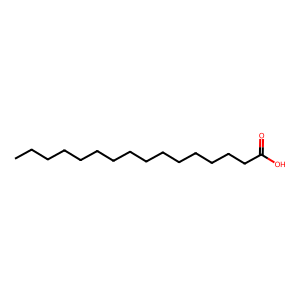

In [6]:
# Test with a simple fatty acid
test_result = test_fatty_acid_input("palmitic acid")
test_result  # Display the molecule